# 0 Set paths, devices, etc.

In [1]:
import numpy as np
import pandas as pd
import torch
import sys
import os

from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

from datasets import Dataset, DatasetDict, load_from_disk
import torch.nn as nn

from transformers import PreTrainedTokenizerFast, TrainingArguments, Trainer, default_data_collator, MambaConfig

from sklearn.metrics import f1_score, confusion_matrix #, accuracy_score, precision_score, recall_score
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns

import bitsandbytes as bnb

import accelerate

from hf_mamba_classification import MambaForSequenceClassification


ModuleNotFoundError: No module named 'datasets'

In [ ]:
# data_dir = 'drive/MyDrive/neuro2voc/task_1/data/'
data_dir = '/home/zubat/Fei/Task_3/data/'

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# 1 Load data and inspect

### 1.0 select what you want to load

In [ ]:
before_int = 750
after_int = 750

In [ ]:
before = str(before_int)
after = str(after_int)
print(before, after)

### 1.1 Load the hugging face dataset

In [ ]:
data_labels_dir = os.path.join(data_dir, "2_datasets", f"dataset_{before}_{after}")

print(f"Loading dataset from: {data_labels_dir}")
hf_dataset = load_from_disk(data_labels_dir)

print(hf_dataset)
print("Number of samples:", len(hf_dataset))

Loading dataset from: /home/zubat/Fei/Task_3/data/2_datasets/dataset_750_750
Dataset({
    features: ['data', 'labels'],
    num_rows: 3459
})
Number of samples: 3459


In [ ]:
data = hf_dataset['data']
labels = hf_dataset['labels']

In [ ]:
print("Sample data:", data[0])
print("Sample labels:", labels[0])

Sample data: <s><|start|>000000000000000000000000000000000000000000000000000000000000000000000000000<|end|><|start|>000000000000000000000000000000000000000000000000000000000000000000000000000<|end|><|start|>000000000000000000000000000000000000000000000000000000000000000000000000000<|end|><|start|>000000000000000000000000000000000000000000000000000000000000000000000000000<|end|><|start|>000000000000000000000000000000000000000000000000000000000000000000000000000<|end|><|start|>000000000000000000000000000000000000000000000000000000000000000000000000000<|end|><|start|>000000000000000000000000000000000000000000000000000000000000000000000000000<|end|><|start|>000000000000000000000000000000000000000000000000000000000000000000010000000<|end|><|start|>000000000000000000000000000000000000000000000000000000000000000000000000000<|end|><|start|>000000000000000000000000000000000000000000000000000000000000000000000000000<|end|><|start|>00000000000000000000000000000000000000000000000000000000000000000

### 1.2 Deal with class imbalance

#### 1.2.1 Inspect

Label Distribution:
Label 2: 472 occurrences
Label 3: 638 occurrences
Label 4: 626 occurrences
Label 5: 623 occurrences
Label 6: 541 occurrences
Label 7: 554 occurrences


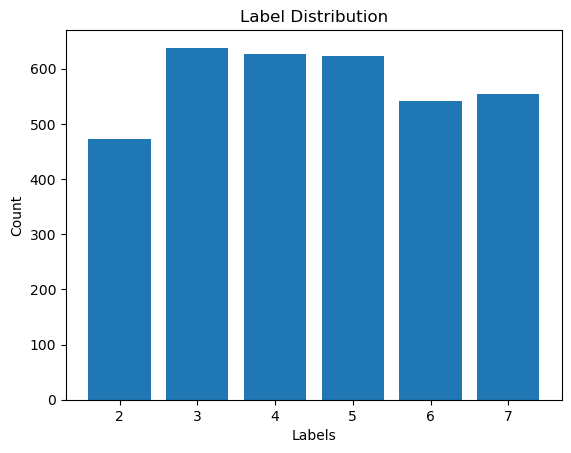

In [ ]:
label_distribution = Counter(labels)
print("Label Distribution:")
for label, count in label_distribution.items():
    print(f"Label {label}: {count} occurrences")

labels, counts = zip(*label_distribution.items())
plt.bar(labels, counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

#### 1.2.2 Drop class 8

In [ ]:
filtered_dataset = hf_dataset.filter(lambda example: example['labels'] != 8)
data = filtered_dataset['data']
labels = filtered_dataset['labels']

#### 1.2.3 Random oversampler

In [ ]:
# filtered_df = pd.DataFrame({'data': data, 'labels': labels})

# # Set the target number of samples per class
# target_samples = filtered_df['labels'].value_counts().max()

# # Resample the data to balance the classes
# balanced_df = pd.DataFrame()

# for class_index in filtered_df['labels'].unique():
#     df_class = filtered_df[filtered_df['labels'] == class_index]
#     if len(df_class) < target_samples:
#         # Upsample
#         df_class_balanced = resample(df_class,
#                                      replace=True,
#                                      n_samples=target_samples,
#                                      random_state=123)
#     else:
#         # Downsample
#         df_class_balanced = resample(df_class,
#                                      replace=False,
#                                      n_samples=target_samples,
#                                      random_state=123)
#     balanced_df = pd.concat([balanced_df, df_class_balanced])

# # Shuffle the DataFrame
# balanced_df = balanced_df.sample(frac=1, random_state=123).reset_index(drop=True)

# # Print the new distribution of labels
# print("Resampled Label Distribution:")
# print(balanced_df['labels'].value_counts())

# # Convert back to Hugging Face Dataset
# resampled_dataset = Dataset.from_pandas(balanced_df)


#### 1.2.4 Check again

In [ ]:
# resampled_label_distribution = Counter(resampled_dataset['labels'])

# print("Resampled Label Distribution:")
# for label, count in resampled_label_distribution.items():
#     print(f"Label {label}: {count} occurrences")

# labels, counts = zip(*resampled_label_distribution.items())
# plt.bar(labels, counts)
# plt.xlabel('Labels')
# plt.ylabel('Count')
# plt.title('Resampled Label Distribution')
# plt.show()

### 1.3 Load tokenizer trained from the previous step

In [ ]:
tokenizer_dir = f"{data_dir}/3_tokenizers/tokenizer_{before}_{after}"
tokenizer = PreTrainedTokenizerFast.from_pretrained(tokenizer_dir)
print("Loaded tokenizer:")
print(f"Path: {tokenizer_dir}")

Loaded tokenizer:
Path: /home/zubat/Fei/Task_3/data//3_tokenizers/tokenizer_750_750


# 2 Prepare for the model

### 2.1 Tokenize function

In [ ]:
def tokenize_function(examples):
    # without padding, truncation, or max length
    return tokenizer(examples["data"], add_special_tokens=True)

In [ ]:
# batch_size = 1
# tokenized_dataset = filtered_dataset.map(tokenize_function, batched=True, batch_size=batch_size)
tokenized_dataset = filtered_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/3454 [00:00<?, ? examples/s]

In [ ]:
token_lengths = [len(tokens) for tokens in tokenized_dataset['input_ids']]
if len(set(token_lengths)) != 1:
    print(f"Token lengths are not uniform: {len(set(token_lengths))}. Check your data.")
else:
    print(f"Uniform token length: {set(token_lengths)}")

Uniform token length: {3752}


In [ ]:
print("Example tokenized data:")
print(tokenized_dataset[0]['data'])
print(tokenized_dataset[0]['input_ids'])
print(tokenized_dataset[0]['labels'])

Example tokenized data:
<s><|start|>000000000000000000000000000000000000000000000000000000000000000000000000000<|end|><|start|>000000000000000000000000000000000000000000000000000000000000000000000000000<|end|><|start|>000000000000000000000000000000000000000000000000000000000000000000000000000<|end|><|start|>000000000000000000000000000000000000000000000000000000000000000000000000000<|end|><|start|>000000000000000000000000000000000000000000000000000000000000000000000000000<|end|><|start|>000000000000000000000000000000000000000000000000000000000000000000000000000<|end|><|start|>000000000000000000000000000000000000000000000000000000000000000000000000000<|end|><|start|>000000000000000000000000000000000000000000000000000000000000000000010000000<|end|><|start|>000000000000000000000000000000000000000000000000000000000000000000000000000<|end|><|start|>000000000000000000000000000000000000000000000000000000000000000000000000000<|end|><|start|>000000000000000000000000000000000000000000000000000000

### 2.2 Train Test Split

In [ ]:
# 0.7 train
train_rest_split = tokenized_dataset.train_test_split(test_size=0.3)
# 0.15 val + 0.15 test
val_test_split = train_rest_split['test'].train_test_split(test_size=0.5)

dataset_dict = DatasetDict({
    'train': train_rest_split['train'],
    'validation': val_test_split['train'],
    'test': val_test_split['test']
})

### 2.3 Data collator

In [ ]:
data_collator = default_data_collator

### 2.4 Model Config

#### 2.4.1 Number of labels

In [ ]:
unique_labels = sorted(set(hf_dataset['labels']))
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()}

print("label2id:", label2id)
print("id2label:", id2label)

num_labels = len(unique_labels)
print("number of labels =", num_labels)

number of labels = 6


#### 2.4.2 Number of tokens

In [ ]:
vocab_size = tokenizer.vocab_size
print(vocab_size)
print(tokenizer)

5600

#### 2.4.4 Pad token id

In [ ]:
pad_token_id = tokenizer.pad_token_id
pad_token_id

2

#### 2.4.5 Model Path

In [ ]:
model_path = 'state-spaces/mamba-130m-hf'

#### 2.4.6 Label2id

In [ ]:
unique_labels = sorted(set(hf_dataset['labels']))
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()}

# Print mappings for verification
print("label2id:", label2id)
print("id2label:", id2label)

### 2.5 Load the model

In [ ]:
configuration = MambaConfig(
    num_labels=num_labels,
    use_cache=False,
    # hidden_size=768,
    # hidden_dropout_prob=0.1,
    # num_attention_heads=num_attention_heads,
    # num_hidden_layers=num_hidden_layers
)
model = MambaForSequenceClassification(configuration)
model.resize_token_embeddings(len(tokenizer))
model.config

MambaConfig {
  "bos_token_id": 0,
  "conv_kernel": 4,
  "eos_token_id": 0,
  "expand": 2,
  "hidden_act": "silu",
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.1,
  "intermediate_size": 1536,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "mamba",
  "num_hidden_layers": 32,
  "pad_token_id": 0,
  "rescale_prenorm_residual": false,
  "residual_in_fp32": true,
  "state_size": 16,
  "time_step_floor": 0.0001,
  "time_step_init_scheme": "random",
  "time_step_max": 0.1,
  "time_step_min": 0.001,
  "time_step_rank": 48,
  "time_step_scale": 1.0,
  "transformers_version": "4.40.2",
  "use_bias": false,
  "use_cache": false,
  "use_conv_bias": true,
  "vocab_size": 5600
}

In [ ]:
model = MambaForSequenceClassification.from_pretrained(
        model_path,
        num_labels=num_labels,
        use_cache=False
)
model.resize_token_embeddings(len(tokenizer))
model.config

/home/zubat/miniforge3/envs/neuro2voc/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MambaForSequenceClassification were not initialized from the model checkpoint at state-spaces/mamba-130m-hf and are newly initialized: ['classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MambaConfig {
  "_name_or_path": "state-spaces/mamba-130m-hf",
  "architectures": [
    "MambaForCausalLM"
  ],
  "bos_token_id": 0,
  "conv_kernel": 4,
  "d_inner": 1536,
  "d_model": 768,
  "eos_token_id": 0,
  "expand": 2,
  "fused_add_norm": true,
  "hidden_act": "silu",
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.1,
  "intermediate_size": 1536,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "mamba",
  "n_layer": 24,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "pad_vocab_size_multiple": 8,
  "rescale_prenorm_residual": false,
  "residual_in_fp32": true,
  "rms_norm": true,
  "ssm_cfg": {},
  "state_size": 16,
  "time_step_floor": 0.0001,
  "time_step_init_scheme": "random",
  "time_step_max": 0.1,
  "time_step

### 2.6 Training arguments

#### 2.6.1 Metrics

In [ ]:
metric = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

#### 2.6.2 Optimizer

In [ ]:
optimizer = bnb.optim.Adam8bit(model.parameters())

#### 2.6.3 Training Arguments

In [ ]:
training_args = TrainingArguments(
    output_dir = "./results",
    num_train_epochs = 120,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size = 64,
    evaluation_strategy = "epoch",
    save_strategy = "no",
    # gradient_accumulation_steps = 2,
    learning_rate = 1.25e-6,
    warmup_steps = 500,
    weight_decay = 0.01,
    logging_dir = "./logs",
    # gradient_checkpointing=True, # turn off this if using mamba
    fp16=True
)

### 2.7 Wrap everything above into trainer

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict['train'],
    eval_dataset=dataset_dict['validation'],
    compute_metrics = compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
    optimizers=(optimizer, None)
)

# 3 TRAIN

In [ ]:
trainer.train()

  0%|          | 0/4560 [00:00<?, ?it/s]

/opt/conda/conda-bld/pytorch_1711403380481/work/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [2,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1711403380481/work/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [6,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1711403380481/work/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [9,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1711403380481/work/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [11,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1711403380481/work/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [20,0,0] Assertion `t >= 0 && t < n_

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# 4 Test

In [ ]:
test_result = trainer.evaluate(dataset_dict['train'])
print(test_result)

  0%|          | 0/124 [00:00<?, ?it/s]

{'eval_loss': 1.5894711017608643, 'eval_accuracy': 0.301010101010101, 'eval_runtime': 138.6461, 'eval_samples_per_second': 28.562, 'eval_steps_per_second': 0.894, 'epoch': 120.0}


In [ ]:
test_result = trainer.evaluate(dataset_dict['test'])
print(test_result)

  0%|          | 0/27 [00:00<?, ?it/s]

{'eval_loss': 1.7286062240600586, 'eval_accuracy': 0.21790341578327443, 'eval_runtime': 29.6963, 'eval_samples_per_second': 28.589, 'eval_steps_per_second': 0.909, 'epoch': 120.0}


In [ ]:
predictions = trainer.predict(dataset_dict['test'])
logits = predictions.predictions
predicted_classes = np.argmax(logits, axis=-1)
true_labels = dataset_dict['test']['labels']

  0%|          | 0/27 [00:00<?, ?it/s]

# 5 Result

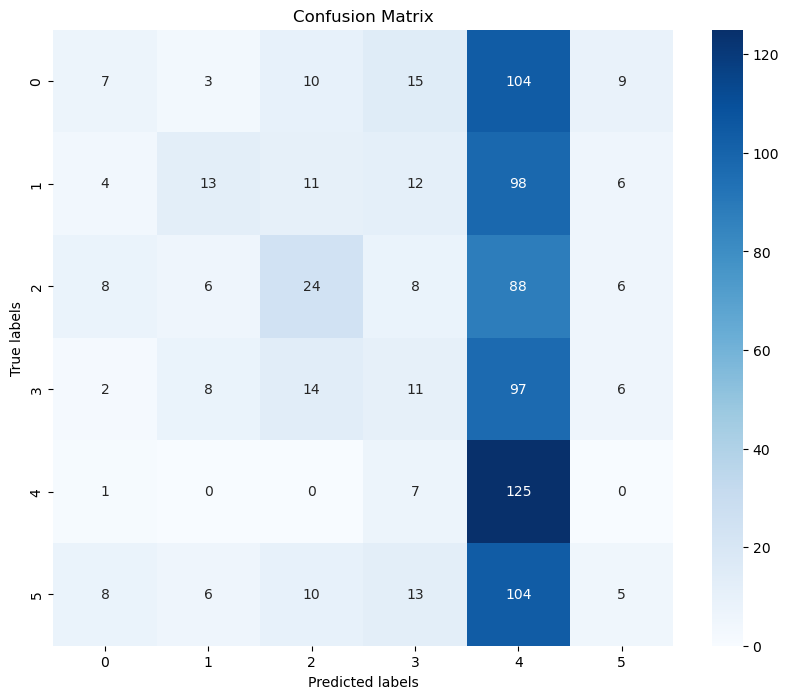

In [ ]:
cm = confusion_matrix(true_labels, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


temporal 120: doesnt work, predict only label 1 and 5

spatial data: doesnt work, predict only label

In [ ]:
name_model = "spatial_600ms_150epochs"
trainer.save_model(f"{data_dir}5_models/{name_model}")

# Archived Codes

In [ ]:
from datasets import load_dataset
from trl import SFTTrainer
from peft import LoraConfig
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments
model_id = "state-spaces/mamba-130m-hf"
model = AutoModelForCausalLM.from_pretrained(model_id)
dataset = load_dataset("Abirate/english_quotes", split="train")
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    logging_dir='./logs',
    logging_steps=10,
    learning_rate=2e-3
)
lora_config =  LoraConfig(
        r=8,
        target_modules=["x_proj", "embeddings", "in_proj", "out_proj"],
        task_type="CAUSAL_LM",
        bias="none"
)
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    peft_config=lora_config,
    train_dataset=dataset,
    dataset_text_field="quote",
)
trainer.train()

In [ ]:
input_ids = torch.tensor([[101, 102, ...]])  # Example input tensor
outputs = model(input_ids)
print(outputs.logits.shape)  # This should output (1, 6) for your configuration


In [ ]:
test_input = torch.tensor(dataset_dict['train']['input_ids'][1], device=device)

In [ ]:
model = model.to(device)

In [ ]:
device

device(type='cuda')

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Prepare the test input and add a batch dimension if necessary
test_input = torch.tensor(dataset_dict['train']['input_ids'][1], device=device)
if test_input.ndim == 1:
    test_input = test_input.unsqueeze(0)  # Reshape to [1, sequence_length]

# Print the adjusted input shape
print("Adjusted Input Shape:", test_input.shape)

# Try to get the output from the model
try:
    output = model(test_input)
    # Check what keys are in the output dictionary
    print("Output Keys:", output.keys())
    # Access logits if available
    if 'logits' in output:
        print("Logits Shape:", output['logits'].shape)
    else:
        print("Logits key not found in model output.")
except Exception as e:
    print("Error during model evaluation:", e)


Adjusted Input Shape: torch.Size([1, 1800])
Output Keys: dict_keys(['logits'])
Logits Shape: torch.Size([6])


In [ ]:
example_inputs = torch.tensor(tokenized_dataset[500]['input_ids'], device=device)
example_labels = torch.tensor(tokenized_dataset[500]['labels'], device=device)

model.eval()
with torch.no_grad():
    outputs = model(example_inputs.unsqueeze(0))  # Add batch dimension
    logits = outputs['logits']
    print(f"Output logits: {logits}")

# Check outputs
predictions = torch.argmax(logits, dim=-1)
print(f"Predictions: {predictions}")
print(f"Label: {example_labels}")


Output logits: tensor([-0.5986,  1.3730,  0.0273,  0.9082, -0.9707,  1.2109], device='cuda:0')
Predictions: 1
Label: 5


In [ ]:
for i in range(5):
    print(f"Input IDs: {dataset_dict['train'][i]['input_ids']}")
    print(f"Label: {dataset_dict['train'][i]['labels']}")

Input IDs: [0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 112, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 92, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 111, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 97, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 55, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 68, 1, 0, 20, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12,

In [ ]:
for i, data in enumerate(tokenized_dataset):
    print(f"Input IDs Shape: {torch.tensor(data['input_ids']).shape}")  # Expected: [1, 1800] if batch size is 1
    print(f"Labels: {torch.tensor(data['labels'])}")  # Should show only one label per batch
    if i == 5:  # Check only the first batch to avoid flooding the output
        break


Input IDs Shape: torch.Size([1800])
Labels: 0
Input IDs Shape: torch.Size([1800])
Labels: 0
Input IDs Shape: torch.Size([1800])
Labels: 0
Input IDs Shape: torch.Size([1800])
Labels: 0
Input IDs Shape: torch.Size([1800])
Labels: 1
Input IDs Shape: torch.Size([1800])
Labels: 1


In [ ]:
example_inputs

[0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 151,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 22,
 1,
 0,
 20,
 1,
 0,
 12,
 1,
 0,
 56,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 75,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 34,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 4436,
 1,
 0,
 12,
 1,
 0,
 22,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 68,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 75,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 35,
 1,
 0,
 12,
 1,
 0,
 95,
 1,
 0,
 20,
 1,
 0,
 12,
 1,
 0,
 99,
 1,
 0,
 68,
 1,
 0,
 12,


In [ ]:
import torch
from torch.utils.data import DataLoader

# Assuming you have a dataset and a DataLoader set up
subset_loader = DataLoader(dataset, batch_size=10, shuffle=True)  # Small batch size for testing

model.eval()  # Set model to evaluation mode to disable dropout, batch norm, etc.
with torch.no_grad():  # Disable gradient computation
    for batch in subset_loader:
        inputs, labels = batch['input_ids'], batch['labels']
        inputs, labels = inputs.to(device), labels.to(device)  # Ensure data is on the correct device

        outputs = model(inputs)
        logits = outputs['logits']
        predictions = torch.argmax(logits, dim=-1)

        # Check shapes and content
        print("Logits Shape:", logits.shape)
        print("Predictions Shape:", predictions.shape)
        print("Labels Shape:", labels.shape)
        print("First 5 Predictions:", predictions[:5])
        print("First 5 Labels:", labels[:5])

        # Break after first batch to just see one batch of outputs
        break


KeyError: 'input_ids'

In [ ]:
class SPKDataset(Dataset):
    def __init__(self, dataset, label, split='train'):
        self.dataset = dataset
        self.split = split
        self.label = label
        self.label2id = {label: label - 2 for label in range(2, 9)}

    def __getitem__(self, item):
        data = self.dataset[item]
        label = self.label[item]
        mapped_label = self.label2id.get(label, label)
        return data, mapped_label

    def __len__(self):
        return len(self.dataset)

In [ ]:
class SPKNoPadCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        data, labels = zip(*batch)

        # tokenizer without padding and truncation
        inputs = self.tokenizer(list(data), return_tensors='pt')

        # extract input_ids and attention_mask
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        labels_tensor = torch.tensor(labels, dtype=torch.long)

        return input_ids, attention_mask, labels_tensor

In [ ]:
class SPKPadCollator:
    def __init__(self, tokenizer, max_len=512):
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __call__(self, batch):
        data, labels = zip(*batch)

        # tokenize WITH padding
        input_ids = []
        attention_mask = []
        for datapoint in data:
            encoded = self.tokenizer.encode(datapoint)
            ids = encoded.ids

            # truncate
            ids = ids[:self.max_len]

            # create attention mask and pad input_ids
            mask = [1] * len(ids)
            num_pad = self.max_len - len(ids)
            ids += [self.tokenizer.token_to_id("[PAD]")] * num_pad
            mask += [0] * num_pad

            input_ids.append(ids)
            attention_mask.append(mask)

        # convert to tensors
        input_ids_tensor = torch.tensor(input_ids, dtype=torch.long)
        attention_mask_tensor = torch.tensor(attention_mask, dtype=torch.long)
        labels_tensor = torch.tensor(labels, dtype=torch.long)

        return input_ids_tensor, attention_mask_tensor, labels_tensor


In [ ]:
def create_dataloader(data, labels, tokenizer, batch_size=64, shuffle=True, max_len=512):
    dataset = SPKDataset(data, labels)
    collator = SPKCollator(tokenizer, max_len=max_len)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collator, num_workers=0)
    return dataloader

In [ ]:
train_loader = create_dataloader(X_train, y_train, wrapped_tokenizer, batch_size=16, shuffle=True, max_len=512)
val_loader = create_dataloader(X_val, y_val, wrapped_tokenizer, batch_size=16, shuffle=False, max_len=512)
test_loader = create_dataloader(X_test, y_test, wrapped_tokenizer, batch_size=16, shuffle=False, max_len=512)

In [ ]:
class_weights_tensor = torch.tensor(list(class_weights.values())).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [ ]:
def train(model, loader, optimizer, mode='train'):
  if mode == 'train':
    model.train()
  else:
    model.eval()

  device = torch.device('cuda')
  amp = True
  scalar = torch.cuda.amp.GradScaler(enabled=amp)
  model.to(device)

  all_predictions = []
  all_labels = []

  for _, (input_ids, attention_mask, aligned_labels) in enumerate(loader):
    input_ids, attention_mask, aligned_labels = input_ids.to(device), attention_mask.to(device), aligned_labels.to(device)

    # use fp16 to speed up
    with torch.cuda.amp.autocast(enabled=amp):

      # feed the input to the model
      outputs = model(input_ids=input_ids.to(device), attention_mask=attention_mask.to(device), labels=aligned_labels.to(device))

      # compute the loss
      loss = outputs.loss
      # loss = loss_fn(outputs.logits, aligned_labels.to(torch.float32)) # with weighted loss
      # loss = loss_fn(outputs.logits, aligned_labels.to(torch.float32)) # with weighted loss

      # store the predictions and labels

      cur_predictions = outputs.logits.argmax(dim=-1).data.cpu().numpy().tolist()
      cur_labels = aligned_labels.data.cpu().numpy().tolist()

      # Check if cur_predictions is a list of lists or a list of ints
      if all(isinstance(item, list) for item in cur_predictions):
        # flatten cur_predictions and cur_labels if they are lists of lists
        cur_predictions = [item for sublist in cur_predictions for item in sublist]
        cur_labels = [item for sublist in cur_labels for item in sublist]

      all_predictions.extend(cur_predictions)
      all_labels.extend(cur_labels)

    # print('{} step {} loss: {}'.format(mode, idx, loss.data.cpu().numpy()))
    if mode == 'train':
      # update the model parameters
      optimizer.zero_grad()
      if scalar is not None:
        scalar.scale(loss).backward()
        scalar.step(optimizer)
        scalar.update()
      else:
        loss.backward()
        optimizer.step()
  return all_predictions, all_labels

#optim = torch.optim.Adam(model.parameters(), lr=1e-5)
#predictions, labels = train(model, train_1k_loader, optim, mode='train')
#true_labels, true_predictions = postprocess(predictions, labels)
#print()

In [ ]:
def obtain_performance(model, train_loader, val_loader, optim):
  best_val_micro_f1 = 0
  best_val_macro_f1 = 0
  best_val_macro_epoch = 0
  best_val_micro_epoch = 0
  for epoch in range(10):
    print('===================== Epoch {} ===================='.format(epoch))
    train_predictions, train_labels = train(model, train_loader, optim, mode='train')
    val_predictions, val_labels = train(model, val_loader, optim, mode='eval')
    # train_true_labels, train_true_predictions = postprocess(train_predictions, train_labels)
    # val_true_labels, val_true_predictions = postprocess(val_predictions, val_labels)
    train_true_labels = train_labels
    train_true_predictions = train_predictions
    val_true_labels = val_labels
    val_true_predictions = val_predictions
    # micro f1
    train_f1 = f1_score(train_true_labels, train_true_predictions, average='micro')
    val_f1 = f1_score(val_true_labels, val_true_predictions, average='micro')
    print('Micro Train F1: {}, Val F1: {}'.format(train_f1, val_f1))
    if val_f1 > best_val_micro_f1:
      best_val_micro_f1 = val_f1
      best_val_micro_epoch = epoch
    # macro f1
    train_f1 = f1_score(train_true_labels, train_true_predictions, average='macro')
    val_f1 = f1_score(val_true_labels, val_true_predictions, average='macro')
    # per class f1
    train_f1s = f1_score(train_true_labels, train_true_predictions, average=None)
    val_f1s = f1_score(val_true_labels, val_true_predictions, average=None)
    print('Per class Train F1s: {}, Val F1s: {}'.format(train_f1s, val_f1s))
    print('Macro Train F1: {}, Val F1: {}'.format(train_f1, val_f1))
    if val_f1 > best_val_macro_f1:
      best_val_macro_f1 = val_f1
      best_val_macro_epoch = epoch
  print('Best Val Micro F1: {}, Best Val Macro F1: {}'.format(best_val_micro_f1, best_val_macro_f1))
  print('Best Val Micro Epoch: {}, Best Val Macro Epoch: {}'.format(best_val_micro_epoch, best_val_macro_epoch))

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(class_weights))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
obtain_performance(model, train_loader, val_loader, optim)

===================== Epoch 0 ====================
Micro Train F1: 0.28793903247183567, Val F1: 0.28488596830305374
Per class Train F1s: [0.00970874 0.34262199 0.         0.10957255 0.00453515 0.37691596
 0.        ], Val F1s: [0.         0.44344164 0.         0.         0.         0.
 0.        ]
Macro Train F1: 0.12047919630429801, Val F1: 0.06334880522606154
===================== Epoch 1 ====================
Micro Train F1: 0.28180914512922467, Val F1: 0.29918824893699264
Per class Train F1s: [0.         0.32688844 0.         0.08872902 0.         0.37985352
 0.        ], Val F1s: [0.         0.         0.         0.         0.         0.46057721
 0.        ]
Macro Train F1: 0.11363870980030381, Val F1: 0.06579674416627704
===================== Epoch 2 ====================
Micro Train F1: 0.29042412193505635, Val F1: 0.28488596830305374
Per class Train F1s: [0.         0.34052701 0.         0.0771725  0.         0.38559197
 0.        ], Val F1s: [0.         0.44344164 0.         0. 

In [ ]:
torch.save(model.state_dict(), 'trained_model.pt')

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model.eval()


In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(

    "distilbert/distilbert-base-uncased", num_labels=2,

)

config.json: 100%|██████████| 483/483 [00:00<00:00, 3.52MB/s]
model.safetensors: 100%|██████████| 268M/268M [00:02<00:00, 104MB/s]  
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
test = model([3]*5000)

TypeError: list indices must be integers or slices, not tuple

In [ ]:
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")

In [ ]:
from transformers import RwkvConfig, RwkvModel
import torch
inputs = {'input_ids':
          torch.tensor([[1]*6000]).to('cuda'),
          'attention_mask': torch.tensor([[1]*6000]).to('cuda')}


# Initializing a Rwkv configuration

configuration = RwkvConfig(context_length=6000)

# Initializing a model (with random weights) from the configuration

model = RwkvModel(configuration)

# Accessing the model configuration

configuration = model.config



/home/zubat/anaconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


: 